In [1]:
import findspark
findspark.init()

In [2]:
import sys
import time
import json
import os

from pyspark import SparkConf, SparkContext, StorageLevel

In [3]:
import importlib

In [4]:
from task2support import *

In [5]:
# importlib.reload(task2support)

In [6]:
conf = SparkConf() \
    .setAppName("task2") \
    .setMaster("local[*]") \
    .set("spark.driver.memory","4g")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")

In [7]:
"""
spark-submit task2.py <filter_threshold> <input_file_path> <betweenness_output_file_path> <community_output_file_path>
"""
filter_threshold = 7
input_file_path = "file:///Users/markduan/duan/USC_course/USC_APDS/INF553/homework/hw4/data/ub_sample_data.csv"
betweenness_output_file_path = "./output/betweenness_jupyter.txt"
community_output_file_path = "./output/community_jupyter.txt"

In [8]:
data_with_header = sc.textFile(input_file_path)
header = data_with_header.first()
distinct_data = data_with_header.filter(lambda l: l != header) \
    .map(lambda l: tuple(l.split(','))) \
    .distinct()\
    .persist(StorageLevel.MEMORY_AND_DISK)
# distinct_data: RDD - [(uid, bid), ...]

In [9]:
uid_map_table = distinct_data.map(lambda x: x[0]).distinct().collect()
bid_map_table = distinct_data.map(lambda x: x[1]).distinct().collect()

In [10]:
baskets = distinct_data.map(lambda x: (uid_map_table.index(x[0]), bid_map_table.index(x[1])))\
    .map(lambda x: (x[0], [x[1]])) \
    .reduceByKey(lambda x, y: x + y) \
    .collectAsMap()

In [11]:
baskets[5]

[947,
 92,
 948,
 453,
 456,
 432,
 949,
 465,
 310,
 443,
 57,
 489,
 950,
 466,
 951,
 952,
 406,
 462,
 449,
 79,
 394,
 395,
 417,
 953,
 954,
 245,
 458,
 955,
 956,
 400,
 407,
 91,
 490,
 414,
 957,
 21,
 403,
 2,
 958,
 442,
 322,
 959,
 473,
 812,
 960,
 296,
 961,
 325,
 265,
 962,
 963,
 964,
 374,
 965,
 966,
 167,
 384,
 217,
 291,
 967,
 968,
 303,
 360,
 202,
 304,
 969,
 970,
 64,
 312,
 886,
 366,
 971,
 460,
 381,
 972,
 973,
 223,
 305,
 353,
 316,
 268,
 307,
 974,
 285,
 169,
 277,
 297,
 315,
 289,
 975,
 355,
 454,
 464,
 471,
 976,
 321,
 286,
 171,
 368]

In [12]:
uids = sorted(list(baskets.keys()))

In [13]:
uids_length = len(uids)

In [14]:
edges_list = []
vertices_have_link = set([])
for i in range(uids_length):
    uid1 = uids[i]
    set1 = set(baskets[uid1])
    for j in range(i+1, uids_length):
        uid2 = uids[j]
        set2 = set(baskets[uid2])
        if len(set1.intersection(set2)) >= filter_threshold:
            edges_list.append((uid1, uid2, 1))
            vertices_have_link.add(uid1)
            vertices_have_link.add(uid2)

In [15]:
len(edges_list)

498

In [16]:
def buildGraph(vtx_names, edges):
    g = UndirectedGraph()
    # add vertices
    for v in vtx_names:
        g.addVertex(v)
    # add edges
    for e in edges:
        g.addEdge(e[0], e[1], e[2])
    return g

In [17]:
original_g = buildGraph(vertices_have_link, edges_list)

In [18]:
g = buildGraph(vertices_have_link, edges_list)

In [19]:
g.num_edge

498

In [20]:
num_remain_edges = g.num_edge
res = []
visual = []
while(num_remain_edges != 0):
    modularity = g.countModularityDependOnOriginalGraph(original_g)
    g.getBetweenness()
    removed_edges = g.removeEdgesWithHighestBetweenness()
    num_remain_edges -= len(removed_edges)
    res.append((modularity, removed_edges))
    visual.append(modularity)
    

In [21]:
for i, item in enumerate(res):
    print(i, item)

0 (0.15704585409912972, [(1366, 1670)])
1 (0.1570458540991294, [(1376, 1670)])
2 (0.15704585409912974, [(10, 31)])
3 (0.15704585409912974, [(3, 31)])
4 (1.049402428993006, [(0, 3)])
5 (1.0494024289930057, [(3, 23)])
6 (1.0494024289930057, [(3, 10)])
7 (1.0494024289930057, [(3, 44)])
8 (1.0494024289930057, [(12, 32)])
9 (1.0494024289930057, [(0, 37)])
10 (1.049402428993006, [(0, 39)])
11 (1.0494024289930057, [(12, 74)])
12 (1.2498064547345586, [(626, 1367)])
13 (1.2981484169609767, [(0, 1)])
14 (1.2981484169609765, [(1, 23)])
15 (1.2981484169609765, [(0, 122)])
16 (1.3054789438879635, [(1670, 1697), (1670, 2576)])
17 (1.364655408783695, [(23, 127)])
18 (1.364655408783695, [(32, 74)])
19 (1.364655408783695, [(23, 74)])
20 (1.3745100885469288, [(1, 4)])
21 (1.3745100885469288, [(3, 52)])
22 (1.3745100885469288, [(1, 16)])
23 (1.3745100885469288, [(1, 5)])
24 (1.3745100885469315, [(3, 41)])
25 (1.3745100885469315, [(3, 12)])
26 (1.374510088546932, [(3, 18)])
27 (1.374510088546932, [(3, 26)

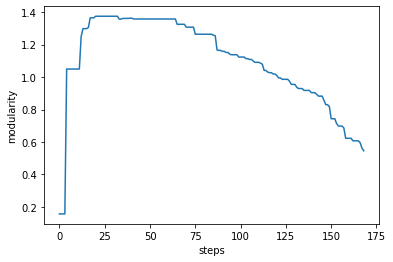

In [22]:
import numpy as np 
from matplotlib import pyplot as plt 
 
x = np.array(list(range(len(visual))))
y = np.array(visual)
# plt.title("Matplotlib demo") 
plt.xlabel("steps") 
plt.ylabel("modularity") 
plt.plot(x, y) 
plt.show()

In [23]:
DECIMAL_ACCURACY = 0.00000000001
largest_i = None
largest_item = res[0]
for i, item in enumerate(res):
    if item[0] - largest_item[0] > DECIMAL_ACCURACY:
        largest_item = item
        largest_i = i

In [24]:
largest_item

(1.3745100885469288, [(1, 4)])

In [25]:
edges_should_be_removed = [i for x in res[:largest_i] for i in x[1]]

In [26]:
edges_should_be_removed

[(1366, 1670),
 (1376, 1670),
 (10, 31),
 (3, 31),
 (0, 3),
 (3, 23),
 (3, 10),
 (3, 44),
 (12, 32),
 (0, 37),
 (0, 39),
 (12, 74),
 (626, 1367),
 (0, 1),
 (1, 23),
 (0, 122),
 (1670, 1697),
 (1670, 2576),
 (23, 127),
 (32, 74),
 (23, 74)]

In [27]:
len(edges_should_be_removed)

21

In [28]:
g = buildGraph(vertices_have_link, edges_list)

In [29]:
for e in edges_should_be_removed:
    g.removeEdge(e)

In [30]:
g.num_edge

477

In [31]:
res = g.getConnectedGraphs()

In [32]:
for group in res:
    for i in range(len(group)):
        group[i] = uid_map_table[group[i]]

In [33]:
for r in res:
    print(r)

['39FT2Ui8KUXwmUt6hnwy-g', 'bSUS0YcvS7UelmHvCzNWBA', 'DKolrsBSwMTpTJL22dqJRQ', 'sdLns7062kz3Ur_b8wgeYw', '_VTEyUzzH92X3w-IpGaXVA', 'qtOCfMTrozmUSHWIcohc6Q', 'zBi_JWB5uUdVuz3JLoAxGQ', 'KLB3wIYUwKDPMbijIE92vg', '1KQi8Ymatd4ySAd4fhSfaw', '_Pn-EmWO-pFPFg81ZIEiDw', 'dTeSvET2SR5LDF_J07wJAQ', 'ay4M5J28kBUf0odOQct0BA', 'OoyQYSeYNyRVOmdO3tsxYA', 'PE8s8ACYABRNANI-T_WmzA', '79yaBDbLASfIdB-C2c8DzA', 'R4l3ONHzGBakKKNo4TN9iQ', 'bHufZ2OTlC-OUxBDRXxViw', 'ChshgCKJTdIDg17JKtFuJw', 'B0ENvYKQdNNr1Izd2r-BAA', '0FVcoJko1kfZCrJRfssfIA', '4pc_EyanaC3ARh0MZZyouA', '2XYdguaaZ7dgi6fAlddujg', 'bE7Yd0jI_P6g27MWEKKalA', 'sBqCpEUn0qYdpSF4DbWlAQ', '7RCz4Ln_FaTvNrdwe251Dg', 'y6jsaAXFstAJkf53R4_y4Q', 'tL2pS5UOmN6aAOi3Z-qFGg', 'dW6bAWM1HbPdk_cGS_a2HA', 'CebjpVd3PsofCgotWp60pg', '2quguRdKBzul3GpRi9e1mA', 'T88y73qdOSutuvzLlhWtqQ', 'DkLSyxogCcJXY5DbTZ-f2A', 'WoKCLSctS7G2547xKcED-Q', 'bJguBxPlnTW29tRTAF0nkQ', 'tRZAC_H5RHrjvyvtufcNXQ', 'KtE55izPs1ubJn3ofF2IrA', 'hqmnMdDS-Opjp3BfBJA8qA', '4PQhC-zTQ4ACEN0-r39JuQ', 'hd343st7cO

In [34]:
def rearrageCommunity(res):
    for item in res:
        item.sort()
    res.sort(key=lambda x: x[0])
    res.sort(key=lambda x: len(x))
    return res

In [35]:
res = rearrageCommunity(res)

In [36]:
for r in res:
    print(r)

['23y0Nv9FFWn_3UWudpnFMA', 'eqWEgMH-DCP74i82BEAZzw']
['3Vd_ATdvvuVVgn_YCpz8fw', 'jSbXY_rno4hYHQCFftsWXg']
['453V8MlGr8y61PpsDAFjKQ', 'gH0dJQhyKUOVCKQA6sqAnw']
['46HhzhpBfTdTSB5ceTx_Og', 'YVQFzWm0H72mLUh-8gzd5w']
['F47atsRPw-KHmRVk5exBFw', 'JeOHA8tW7gr-FDYOcPJoeA']
['Si3aMsOVGSVlsc54iuiPwA', 'd5WLqmTMvmL7-RmUDVKqqQ']
['_m1ot2zZetDgjerAD2Sidg', 'vENR70IrUsDNTDebbuxyQA']
['gUu0uaiU7UEUVIgCdnqPVQ', 'jJDUCuPwVqwjbth3s92whA']
['98rLDXbloLXekGjieuQSlA', 'MJ0Wphhko2-LbJ0uZ5XyQA', 'QYKexxaOJQlseGWmc6soRg']
['9W73B44Iw8WslrTNB2CdCg', 'UmTMCfPlhA6kJLAsLycSfg', 'Uo5dPwoDpYBzOnmUnjxJ6A']
['CLbpPUqP6XpeAfoqScGaJQ', 'drTMOo4p8nL0pnMNEyat2A', 'tX0r-C9BaHYEolRUfufTsQ', 'xhlcoVm3FOKcxZ0phkdO6Q']
['Gr-MqCunME2K_KmsAwjpTA', 'QRsuZ_LqrRU65dTs5CL4Lw', '_6Zg4ukwS0kst9UtkfVw3w', 'lJFBgSAccsMGwIjfD7LMeQ']
['Cf0chERnfd06ltnN45xLNQ', 'CyrRjt_7iJ8_lSHeH1_TlA', 'JhFK9D3LYl23Se3x4oPUxA', 'ZW-XoteNlRuuK-19q1spmw', 'lL-wNa0TKK6LXrlcVmjYrQ']
['EY8h9IJimXDNbPXVFpYF3A', 'LiNx18WUre9WFCEQlUhtKA', 'hilL60vuuh06sMxs6Ckkog'

In [40]:
len(res)

19

In [37]:
def outputAsFile(res):
    with open(community_output_file_path, 'w', encoding='utf-8') as fp:
        for t in res:
            if len(t) == 1:
                fp.write("'%s'\n" % (t[0]))
            else:
                fp.write("'" + ("', '").join(t) + "'\n")

In [38]:
# outputAsFile(res)    